In [100]:
import pandas as pd
df = pd.read_csv('diabetes.csv')

In [101]:
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [102]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [103]:
np.random.seed(0)
msk = np.random.rand(len(df)) < 0.8
train_val_df = df[msk]
test_data = df[~msk]

In [104]:
import math

def calculate_gaussian_likelihood(x, mean_std):
	"""
	Devuelve el likelihood asociado a una variable dado una media y un desvío estándar.
	Recibe:
		1. x: valor de la variable.
		2. mean_std: tupla, lista o np array cuyo primer elemento corresponde a la media y su segundo elemento al desvío estándar.
	"""
	mean = mean_std[0]
	stdev = mean_std[1]
	exponent = math.exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

In [105]:
def calculate_mean_std(set_df, column, outcome):
    """
    Calcula la media y el desvío estándar de una columna de un dataframe para aquellas filas donde el outcome tome un valor determinado.
    Recibe: 
        1. set_df: Dataframe.
        2. column: Nombre de la columna cuyas media y stdev se buscan.
        3. outcome: Valor del outcome sobre el cual se filtra el data set.
    Devuelve:
        np array cuyo primer elemento es la media y el segundo elemento el desvío estándar.
    """
    filtered_df = set_df[[column, 'Outcome']].groupby(['Outcome'])[[column]]
    mean = filtered_df.mean().reset_index().iloc[outcome,1]
    std = filtered_df.std().reset_index().iloc[outcome,1]
    return np.array([mean, std])

In [106]:
def train_model(train_df):
    """
    Función que entrena al modelo dado un DataFrame de entrenamiento.
    Recibe:
        1. train_df: DF de entrenamiento.
    Devuelve:
        *   Matriz de 2 x {Cantidad de columnas del dataframe - 1}.
            Cada celda de la matriz contiene un np array cuyo primer elemento es la media y el segundo elemento el desvío estándar para cada columna y para cada posible outcome.
            La primera fila de la matriz corresponde al outcome 0 y la segunda fila al outcome 1.
            Cada columna de la matriz está asociada a cada columna del dataframe (excepto la columna de outcome).
        *   Priori_probs: Lista con las probabilidades a priori para outcome 0 y outcome 1.
    """
    healthy_p_train = (train_df['Outcome'] == 0).sum()
    sick_p_train = (train_df['Outcome'] != 0).sum()
    total = train_df.shape[0]
    priori_probs = [healthy_p_train / (healthy_p_train + sick_p_train), sick_p_train / (healthy_p_train + sick_p_train)]
    train_matrix =  np.empty([2, len(train_df.columns)-1], dtype = object)
    for ind, column in enumerate(train_df.columns):
        if (ind != train_df.columns.get_loc("Outcome")):
            train_matrix[0][ind] = calculate_mean_std(train_df, train_df.columns[ind], 0)
            train_matrix[1][ind] = calculate_mean_std(train_df, train_df.columns[ind], 1)
    return train_matrix, priori_probs

In [107]:
def pred(row, matrix, priori_probs):
    """
    Función que dada una fila correspondiente a una muestra de un individuo, una matriz entrenada (con los valores de las medias y desvíos estándar) y las probabilidad a priori de cada outcome, calcula si es más probable que el individuo posea diabetes o no.
    Recibe:
        1. Row: Fila con los valores de las características de un individuo. Cada elemento está asociado a una columna del dataframe de entrenamiento utilizado.
        2. Matrix: Matriz resultante de la función train_model.
        3. Priori_probs: Lista con las probabilidades a priori para outcome 0 y outcome 1.
    Devuelve:
        Valor (0 o 1) más probable para el outcome.
    """
    likelihoods_0 = np.array([])
    likelihoods_1 = np.array([])
    for ind, column in enumerate(row):
        likelihoods_0 = np.append(likelihoods_0, math.log(calculate_gaussian_likelihood(column, matrix[0][ind])))
        likelihoods_1 = np.append(likelihoods_1, math.log(calculate_gaussian_likelihood(column, matrix[1][ind])))
    prob_0 = likelihoods_0.sum()
    prob_1 = likelihoods_1.sum()
    prob_0 += math.log(priori_probs[0])
    prob_1 += math.log(priori_probs[1])
    if(prob_1 >= prob_0):
        return 1.0
    else:
        return 0.0

In [108]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import KFold
def k_folding(df, columnsToReplaceNulls, removeCols = []):
    """
    Función que dado un dataframe realiza un k-folding con k=5.
    Recibe:
        Dataframe
    Devuelve:
        Lista que contiene a las matrices de confusión para cada k_i paso.
    """
    dataframe = df.copy()
    kf = KFold(n_splits = 5)
    sub_sets = kf.split(dataframe)
    conf_matrix = []
    train_aucs = []
    val_aucs = []
    models = []
    replaceNullsCols = [n for n in columnsToReplaceNulls if n not in removeCols]
    dataframe = dataframe.drop(removeCols, axis=1)

    for train_index, val_index in sub_sets: 
        train_outcomes = []
        val_outcomes = []
        pred_train_outcomes = []
        pred_val_outcomes = []
        train_df = dataframe.iloc[train_index]
        val_df = dataframe.iloc[val_index]

        ##Reemplazo nulos
        medians = train_df[replaceNullsCols].median()
        train_df[replaceNullsCols] = train_df[replaceNullsCols].replace(np.NaN,medians)
        val_df[replaceNullsCols] = val_df[replaceNullsCols].replace(np.NaN,medians)

        matrix_train, priori_probs = train_model(train_df)
        model =[medians, matrix_train, priori_probs]
        models.append(model)
        ## Train
        for index, row in train_df.iterrows():
            true_outcome = row["Outcome"]
            pred_outcome = pred(row.to_list()[:-1], matrix_train, priori_probs)
            train_outcomes.append(true_outcome)
            pred_train_outcomes.append(pred_outcome)

        ## Validacion
        for index, row in val_df.iterrows():
            true_outcome = row["Outcome"]
            pred_outcome = pred(row.to_list()[:-1], matrix_train, priori_probs)
            val_outcomes.append(true_outcome)
            pred_val_outcomes.append(pred_outcome)

        fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_outcomes, pred_train_outcomes)
        auc_train_i = metrics.auc(fpr_train, tpr_train)

        fpr_val, tpr_val, thresholds_val = metrics.roc_curve(val_outcomes, pred_val_outcomes)
        auc_val_i = metrics.auc(fpr_val, tpr_val)

        val_aucs.append(auc_val_i)
        train_aucs.append(auc_train_i)
        
        conf_matrix.append(metrics.confusion_matrix(val_outcomes, pred_val_outcomes))
    return conf_matrix, train_aucs, val_aucs, models


In [109]:
def plot_all_conf_matrix(conf_matrix):
    """
    Función que dada una lista de matrices de confusión, realiza el gráfico para cada una de ellas.
    """
    for matrix in conf_matrix:
        ylabel = ["Actual [Non-Diabetic]","Actual [Diabetic]"]
        xlabel = ["Pred [Non-Diabetic]","Pred [Diabetic]"]
        sns.set(font_scale = 1.5)
        plt.figure(figsize=(15,6))
        sns.heatmap(matrix, annot=True, xticklabels = xlabel, yticklabels = ylabel, linecolor='white', linewidths=1)
        plt.yticks(rotation=0);

### Sin reemplazar nulos

In [110]:
conf_matrix_nr, train_aucs_nr, val_aucs_nr, models_nr = k_folding(train_val_df, [])

In [111]:
print('AUC Train: ' + str(np.array(train_aucs_nr).mean()))
print('AUC Validation: ' + str(np.array(val_aucs_nr).mean()))

AUC Train: 0.622569658377025
AUC Validation: 0.6304635559347458


### Reemplazando nulos

In [112]:
conf_matrix, train_aucs, val_aucs, models = k_folding(train_val_df,  ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])

C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

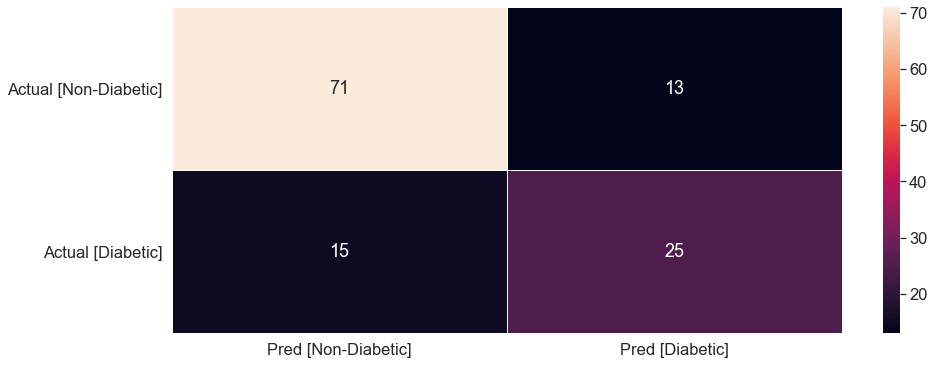

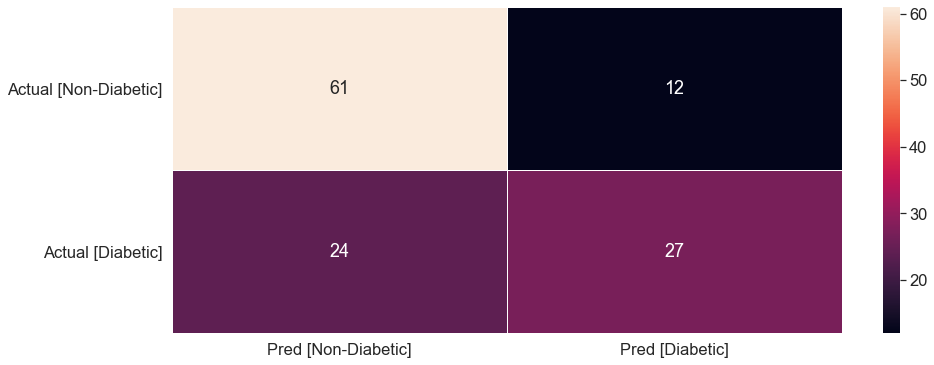

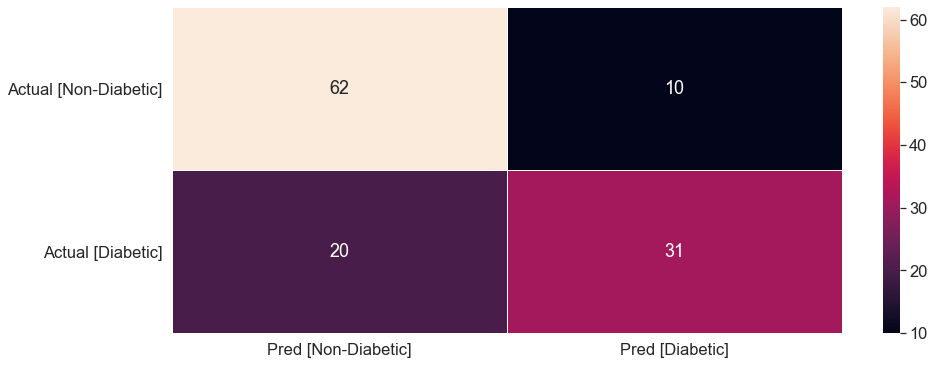

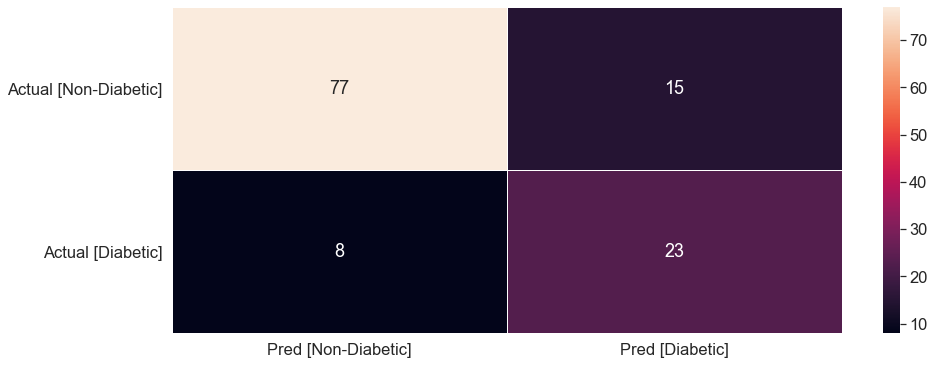

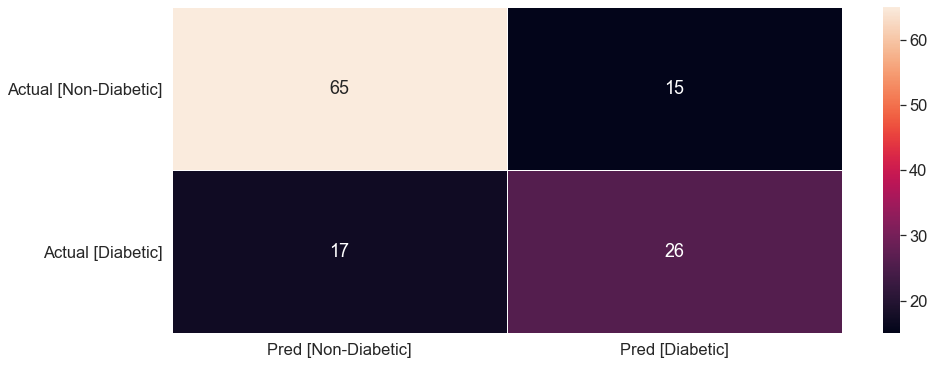

In [113]:
plot_all_conf_matrix(conf_matrix)

In [114]:
print('AUC Train: ' + str(np.array(train_aucs).mean()))
print('AUC Validation: ' + str(np.array(val_aucs).mean()))

AUC Train: 0.7266501220225963
AUC Validation: 0.730026371506695


### Eliminando columnas

In [115]:
bestAuc = np.array(val_aucs).mean()
# Columnas a analizar
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeColsImproved = []
removeColsAuc = []
removeColsAucTrain = []

nullCols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
		
for col in tryRemovingCols:
	print(col)	
	conf_matrix_col, train_aucs_col, val_aucs_col, models_col = k_folding(train_val_df,  ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'], removeCols=[col])
	# Si la métrica mejora se guarda la columna a remover.
	if (np.array(val_aucs_col).mean() > bestAuc):
		removeColsImproved.append(col)
		removeColsAucTrain.append(np.array(train_aucs_col).mean())
		removeColsAuc.append(np.array(val_aucs_col).mean())

BloodPressure
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [116]:
# Se imprimen las columnas que al removerlas aumentaron la métrica.
print(removeColsImproved)
print(removeColsAuc)
print(removeColsAucTrain)

['BloodPressure', 'SkinThickness']
[0.7311926931077994, 0.7312018325106451]
[0.7284894282278769, 0.7321071306975034]


### Eliminando todas las columnas anteriores

In [117]:
conf_matrix_rac, train_aucs_rac, val_aucs_rac, models_rac = k_folding(train_val_df,  ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'], removeCols=removeColsImproved)

C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\pabli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [118]:
print('AUC Train: ' + str(np.array(train_aucs_rac).mean()))
print('AUC Validation: ' + str(np.array(val_aucs_rac).mean()))

AUC Train: 0.729800199237744
AUC Validation: 0.7355080394895606


## Test

In [119]:
## Test
aucs_test = []
for model in models:
    ##Reemplazo nulos
    test_dataframe = test_data.copy()
    columnsWithNulls = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
    test_dataframe[columnsWithNulls] = test_dataframe[columnsWithNulls].replace(np.NaN,model[0])
    test_dataframe = test_dataframe.drop(removeColsImproved, axis=1)

    true_test_outcomes = []
    pred_test_outcomes = []

    for index, row in test_data.iterrows():
        true_outcome = row["Outcome"]
        pred_outcome = pred(row.to_list()[:-1], model[1], model[2])
        true_test_outcomes.append(true_outcome)
        pred_test_outcomes.append(pred_outcome)

    fpr_test, tpr_test, thresholds_test = metrics.roc_curve(true_test_outcomes, pred_test_outcomes)
    auc_test_i = metrics.auc(fpr_test, tpr_test)
    aucs_test.append(auc_test_i)


In [120]:
print('AUC Test: ' + str(np.array(aucs_test).mean()))

AUC Test: 0.5836247086247086
